In [1]:
import pandas as pd

In [10]:
df = pd.read_csv('dataset.csv', index_col=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 241.9+ KB


In [12]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [17]:
df = df.set_index('timestamp')

In [18]:
df

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [19]:
df.isna().sum()

value    0
dtype: int64

<Axes: xlabel='timestamp'>

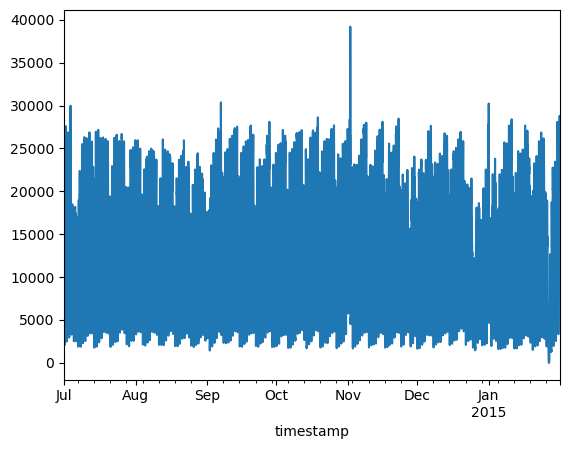

In [20]:
  df['value'].plot()